In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 512
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1457 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['daisy', 'dandelion']

In [5]:
len(dataset)

46

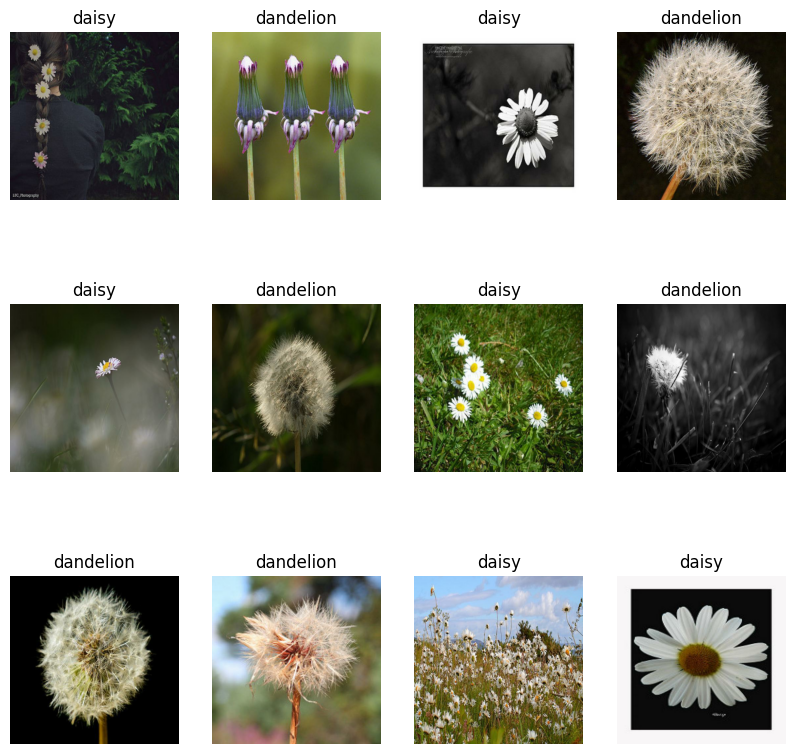

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    #print(image_batch[0].shape) The last parameter of (512,512,3)-> channels
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# 80 ==> training
# 20% ==> 10% validation, 10% test

In [8]:
train_size = 0.8
len(dataset)*train_size

36.800000000000004

In [9]:
train_ds = dataset.take(36)
len(train_ds)

36

In [10]:
test_ds = dataset.skip(36)
len(test_ds)

10

In [11]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

4

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

36

In [16]:
len(val_ds)

4

In [17]:
len(test_ds)

6

In [18]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
#Rescaling images if user inputted img i snot according to required format
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [20]:
# Data augmentation- generating a bigger dataset by flipping, rotating, zooming images and then
# add all those variations to the dataset- so our model is robust 

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
# Using CNN - two parts, convolution+ReLu , pooling and dense layers 
# Kernel size is size of the filter-here first parameter is layers.Conv2D => 32
# Pooling - preserving features and reducing size of image
# Flatten will finally flatten layers into a form understandable by neurons for NN
# Softmax activation function normalizes probability of classes

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation, 
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape), #CONVOLUTIONAL LAYER
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax'),
    # Last layer has 3 neurons with softmax activation function 
])
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 512, 512, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 510, 510, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 255, 255, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 253, 253, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 126, 126, 64)       0         
 2D)                                                  

In [25]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/5
36/36 [==============================] - 304s 8s/step - loss: 0.7338 - accuracy: 0.5532 - val_loss: 0.7549 - val_accuracy: 0.4375
Epoch 2/5
36/36 [==============================] - 289s 8s/step - loss: 0.6800 - accuracy: 0.5796 - val_loss: 0.6662 - val_accuracy: 0.6094
Epoch 3/5
36/36 [==============================] - 289s 8s/step - loss: 0.6391 - accuracy: 0.6579 - val_loss: 0.5693 - val_accuracy: 0.7422
Epoch 4/5
36/36 [==============================] - 290s 8s/step - loss: 0.5377 - accuracy: 0.7361 - val_loss: 0.5679 - val_accuracy: 0.7812
Epoch 5/5
36/36 [==============================] - 290s 8s/step - loss: 0.5100 - accuracy: 0.7634 - val_loss: 0.6092 - val_accuracy: 0.7656


In [27]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 14s 2s/step - loss: 0.6643 - accuracy: 0.7604


In [28]:
scores # First parameter is loss and second is accuracy 

[0.6643350720405579, 0.7604166865348816]

In [29]:
history 

In [30]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 36}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
# history.history['accuracy']
# len(history.history['accuracy']

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

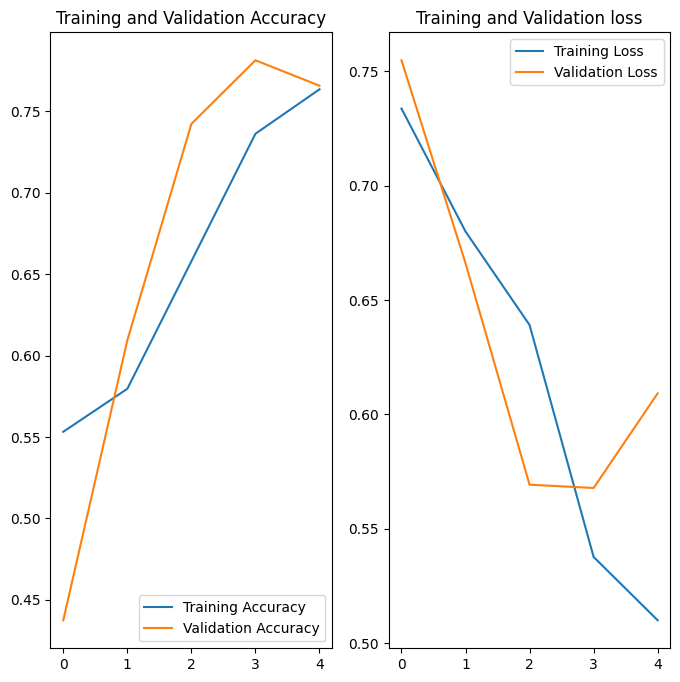

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

first image to predict
actual label: dandelion
1/1 [==============================] - 3s 3s/step
predicted label: dandelion


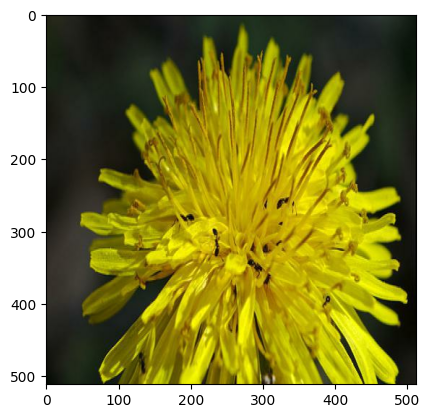

In [35]:
# To run our predictions
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [36]:
# Function takes model and image as input and tells what is predicted class and confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 146ms/step


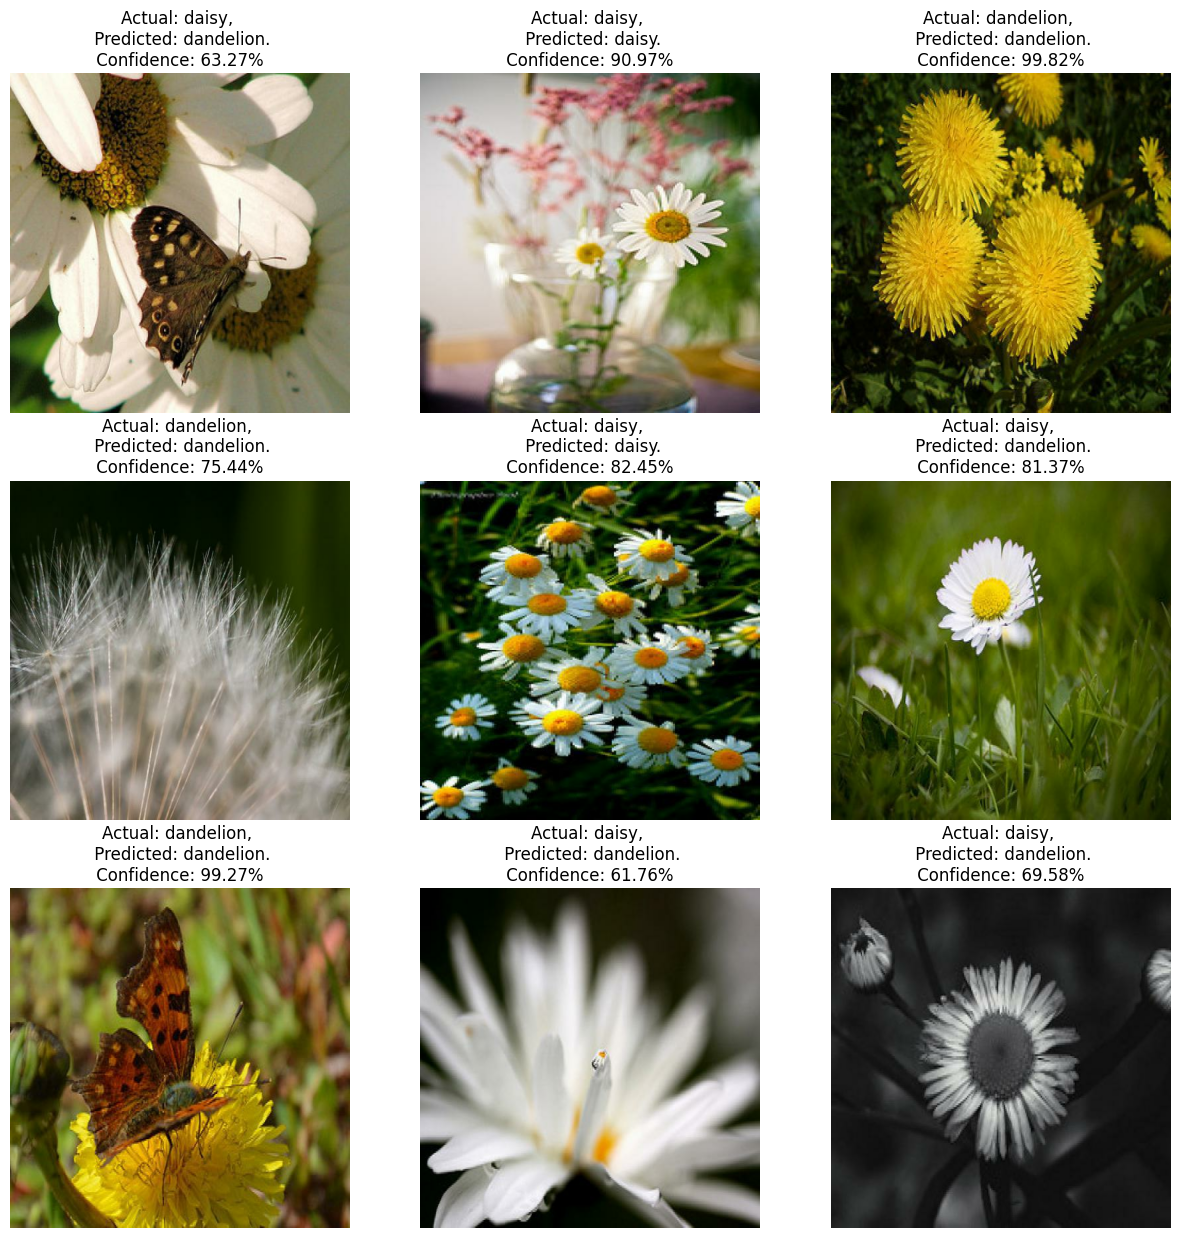

In [37]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}% ")
        
        plt.axis("off")

In [38]:
# Store models with different variations of parameters here- automatically incs5 model version
import os
model_version = max([int(i) for i in os.listdir("./models")+[0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
